In [1]:
# Notebook behavior:

# Enable multiple outputs from one cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# autoreload extension: automaticall refresh imports when code is changed:
%load_ext autoreload
%autoreload 2

# run_ms_analysis.ipynb
---

# Tutorial notebook for processing MCCE microstate file in ms_out folder.

# Required mcce run output files:
### 1. head3.lst
### 2. file in ms_out/, a.k.a. the 'msout file'
 * Notes:
   - The ms_out folder is retained when the `--ms` flag is used at the command line for Step 4: `step4.py --ms`;
   - Format of the msout file name: pHXeHYms.tx at pH point X and Eh point Y;
   - The most typical filename encountered is "pH7eH0ms.txt", meaning the MCCE simulation was a pH titation run at pH7.
---

## Load the needed libraries and modules:

In [2]:
from collections import defaultdict
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import sys

%matplotlib inline

# Module needed to read the microstate file:
import ms_analysis_wc as msa

---
# Inputs
## Required user input: the path to the msout file:
 * e.g. 4lzt/ms_out/pH7eH0ms.txt
## Optional user input: list of residues of interest
---

# Define the path to msout file:

In [8]:
# MCCE microstates file:
msout_file = Path("4lzt/ms_out/pH7eH0ms.txt").resolve()

# Get the related head3.lst path:
h3_path = msout_file.parent.parent.joinpath("head3.lst")
h3_path.exists()

msout_file
h3_path

# More specific name for output folder: KEEP?
outname = "crgms_wc"  # "output"

# Ensure the output directory exists:
output_dir = Path(outname)
if not output_dir.exists():
    output_dir.mkdir()

output_dir

True

PosixPath('/home/cat/projects/raihan/python/microstate_analysis_code/4lzt/ms_out/pH7eH0ms.txt')

PosixPath('/home/cat/projects/raihan/python/microstate_analysis_code/4lzt/head3.lst')

PosixPath('crgms_wc')

In [9]:
! ls -l {output_dir}

total 92
-rw-r--r-- 1 cat users   856 Feb  7 18:08 all_crg_count_res.csv
-rw-r--r-- 1 cat users   213 Feb  7 18:08 cluster4_crg_count_res_june06_king.csv
-rw-r--r-- 1 cat users  8850 Feb  7 18:09 corr.pdf
-rw-r--r-- 1 cat users 18822 Feb  7 18:06 crgms_logcount_vs_all_E_ph7.pdf
-rw-r--r-- 1 cat users 17642 Feb  7 18:07 crgms_logcount_vs_aver_E.pdf
-rw-r--r-- 1 cat users 16195 Feb  7 18:08 crgms_logcount_vs_highest_E.pdf
-rw-r--r-- 1 cat users 15772 Feb  7 18:06 crgms_logcount_vs_lowest_E.pdf


# Residues of interest
Note: Make sure to add the names of your residues of interest, such as quinone, here:

In [10]:
# Which kind of residues to consider (3-letter codes):
res_of_interest = ["ASP", "PL9", "GLU", "ARG", "HIS", "LYS", "TYR", "NTR", "CTR"]

# Specific residues of interest. Here the list supplied must be conformer ids:
choose_resid = ["GLUA0035_", "HISA0015_", "ASPA0119_"]

### Note about the `msa` module:
The loading of the conformers list (into module variable `conformers`) is __performed on import using "./head3.lst" by default__;  
The list will be empty whenever a different location is needed.

### Check whether the conformers list needs reloading:

In [11]:
if not msa.conformers:
    # redo with the appropriate head3.lst path:
    conformers = msa.read_conformers(h3_path)
else:
    conformers = msa.conformers

n_conformers = len(conformers)
print(f"Conformers count: {n_conformers:,}")

Conformers count: 314


# Instantiate `msa.MSout` class with the given msout file:

In [31]:
mc = msa.MSout(msout_file)
print(mc)

Number of microstates: 1,500,000
Number of unique microstates: 394,139
Energies: lowest_E: -184.97; average_E: -179.39; highest_E: -166.75


#### [ optional ]
#### Learn which methods come with the instantiated class (mc)
 * What's in the MSout class?

### In MCCE, residues are divided into fixed or free residue groups.
 * Only free residues appear in the microstate sate list.
 * Fixed residues can be ionizable residues so we need to include their contribution to the total charge, which is referred to here as __background charge__. 

#### Free residues information

In [33]:
# Uncomment to display:

#print("mc.free_residues list holds each free residues' conformers.\nSample data:\n", mc.free_residues[:2])

In [82]:
# Save the free_residues in a pandas.DataFrame, it will be one of the inputs to the function msa.ConcaCrgMsPandas:
free_residues_df = msa.free_residues_df(mc.free_residues, conformers, colname="Residue")
print(f"Number of free residues: {free_residues_df.shape[0]:,}")

Number of free residues: 47


In [147]:
# Uncomment to display:

#free_residues_df.head(3)
#free_residues_df.tail(3)

In [ ]:
# get their net charges into a df for combiing with fixed_res

free_res_crg_df = msa.free_res2sumcrg_df(mc.microstates.values(), mc.free_residues, conformers)

In [ ]:
# Uncomment to display:

#free_res_crg_df.head()

#### Fixed residues charge.
(Make sure to account for fixed residues charge for MD simulation protonation input.)

__For all fixed residues:__

In [173]:
# Note: pass an empty list to get all residues (default is ionizable residues)

background_crg, all_fixed_res_crg_df, all_fixed_res_crg_dict = msa.fixed_residues_info(mc.fixed_iconfs, conformers, [])

print("Background charge:", background_crg)
print("Number of fixed residues:", len(all_fixed_res_crg_dict))

Background charge: 8.0
Number of fixed residues: 81


In [148]:
# Uncomment to display:

#all_fixed_res_crg_df.head()

### Combine free & fixed res with crg and save to csv:

In [174]:
all_res_crg_df = msa.combine_all_free_fixed_residues(free_res_crg_df, all_fixed_res_crg_df)

# Save to csv:
all_res_crg_df.to_csv(output_dir.joinpath("all_res_crg.csv"), index_label="Residue" )

In [164]:
# Uncomment to display:

#all_res_crg_df

__For fixed residues among residues of interest:__  
#### Save the fixed residues in your residues of interest to a separate list, DataFrame & csv:

In [161]:
background_crg, fixed_resoi_crg_df, fixed_resoi_crg_dict = msa.fixed_residues_info(mc.fixed_iconfs,
                                                                                   conformers,
                                                                                   res_of_interest
                                                                                  )
print("Background charge:", background_crg)
n_fixed_resoi = len(fixed_resoi_crg_dict)
if n_fixed_resoi:
    print("Fixed res in residues of interest:", n_fixed_resoi)
    # save to csv:
    fixed_resoi_crg_df.to_csv(output_dir.joinpath("fixed_crg_resoi.csv"), index=False)
else:
    fixed_resoi_crg_df = None
    print("No fixed residues of interest.")

Background charge: 8.0
Fixed res in residues of interest: 25


In [162]:
if n_fixed_resoi:
    fixed_resoi_crg_df.head(3)

,Residue,crg
0,ARGA0005_,1.0
1,GLUA0007_,-1.0
2,LYSA0013_,1.0


#### The following saves sorted microstates attributes (energy, count and microstate state) into a list;
The default sort in .sort_microstates() is by energy.

In [25]:
# mc.sort_microstates() returns a list of sorted ms objects:

ms_orig_lst = [[ms.E, ms.count, ms.state] for ms in mc.sort_microstates()]

### `ms_orig_lst` holds each microstate's attributes, i.e: [ms.E, ms.count, ms.state] sorted by energy.
#### The first attribute is the microstate energy; the second is the multiplicity of that state (mso.microstates holds unique ms info), the last one is the list of conformers in that state.

#### The conformer numbers align with head3.lst. Head3.lst starts at 1; ms lists start at 0.

In [13]:
# Sample data (uncomment to display):

#print(ms_orig_lst[:2])

### This will map the microstate conformer id to its corresponding charge, and convert the conformer microstates from `mc` to charge microstates:

In [113]:
# Map conf index to conf charge:
id_vs_charge = msa.iconf2crg(conformers)

# This list is identical to ms_orig_lst but now simply give the charge of the coformers selected for each residue.
crg_orig_lst = msa.ms2crgms(ms_orig_lst, id_vs_charge)

In [15]:
# Sample data (uncomment to display):

#print(crg_orig_lst[:2])

---
# Process the charge microstates into various outputs

# [ Cat ]
#### Only the unfiltered data is plotted and the corresponding figure saved with a wierd name: output/all_en_cr_ph7_vs_log(count).pdf.
#### We could have of the processing bounds saved into a dict & wrap the following processing into one function, but the names of the figures are needed.

## Unfiltered charge microstates

In [171]:
crgms_files = msa.findUniqueCrgmsCountOrder(crg_orig_lst)
print(f"Size of 'all_crg_ms_unique' (crgms_files[0]): {len(crgms_files[0]):,}")

# crgms_files:
#  0: all_crg_ms_unique,
#  1: all_count,
#  2: unique_crg_state_order,
#  3: energy_diff_all (used in plot)

all_crg_count_res = msa.ConcaCrgMsPandas(crgms_files[0],
                                         crgms_files[1],
                                         crgms_files[2], 
                                         free_residues_df,
                                         background_crg,
                                         res_of_interest
                                         )

[INFO]: find_uniq_crgms_count_order:
	No energy bounds given: All microstates are selected.
[INFO]: find_uniq_crgms_count_order:
	Number of charge ms: 394,139
[INFO]: find_uniq_crgms_count_order:
	Number of unique charge ms: 15


Size of 'all_crg_ms_unique' (crgms_files[0]): 15


In [17]:
# Sample data (uncomment to display):

#all_crg_count_res.head(3)

### This will plot the tautomer charge distribution of unqiue charge microstates based on the occupancy. 
Each dot are unique charge microstate and color coded based on the energy difference of that microstate appear in Monte Carlo run. Total charge is sum of background and free charge (protein charge).

[INFO]: jointplot:
	Figure saved: crgms_wc/crgms_logcount_vs_all_E_ph7.pdf
[INFO]: jointplot:
	Figure saved: crgms_wc/crgms_logcount_vs_all_E_ph7.png


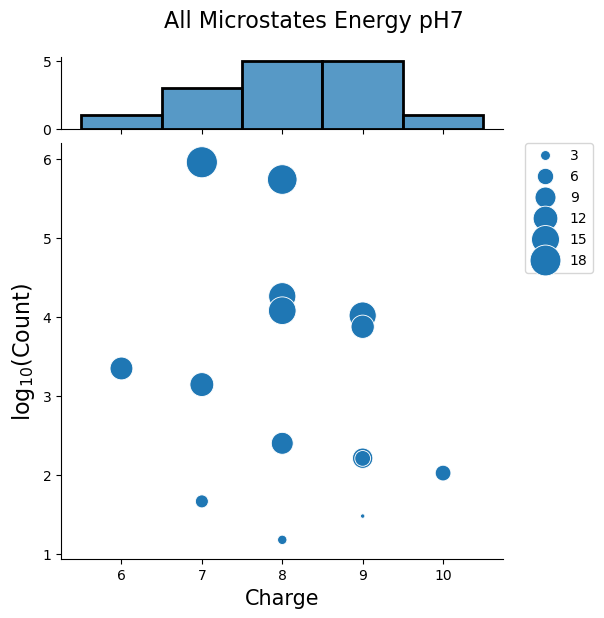

In [167]:
title = "All Microstates Energy pH7" 
msa.jointplot(crgms_files,
              background_crg,
              title,
              out_dir=output_dir,
              save_name="crgms_logcount_vs_all_E_ph7.pdf",
              show=True)

# [ Raihan ]
#### A very important thing here in this dot plot we need to be clear what is these dots numbers mean?
#### In fact we have a different type of output figure for this. I will share with you. I believe these values are eneergy range of the microstates, but the numbers sometimes do not make sense.
---

#### This is to get the unique charge microstates >= lowest energy + 1.36 kcal/mol. 
Make sure your supply list is sorted based on energy in ascending order. 
The order in the dataframe is within the selected energy range.

In [176]:
begin_E = crg_orig_lst[0][0]
end_E = crg_orig_lst[0][0] + 1.36
print(f"Using energy bounds ({begin_E}, {end_E})")

lowest_crgms_files = msa.findUniqueCrgmsCountOrder(crg_orig_lst,
                                                   begin_energy = begin_E,
                                                   end_energy = end_E
                                                   )
low_crg_count_res = msa.ConcaCrgMsPandas(lowest_crgms_files[0],
                                         lowest_crgms_files[1],
                                         lowest_crgms_files[2], 
                                         free_residues_df,
                                         background_charge,
                                         res_of_interest)

[INFO]: find_uniq_crgms_count_order:
	Number of energy-filtered charge ms: 2,198
[INFO]: find_uniq_crgms_count_order:
	Number of unique charge ms: 2


Using energy bounds (-184.972214, -183.612214)


In [177]:
# Sample data (uncomment to display):

#low_crg_count_res.head(3) 

[INFO]: jointplot:
	Figure saved: crgms_wc/crgms_logcount_vs_lowest_E.pdf
[INFO]: jointplot:
	Figure saved: crgms_wc/crgms_logcount_vs_lowest_E.png


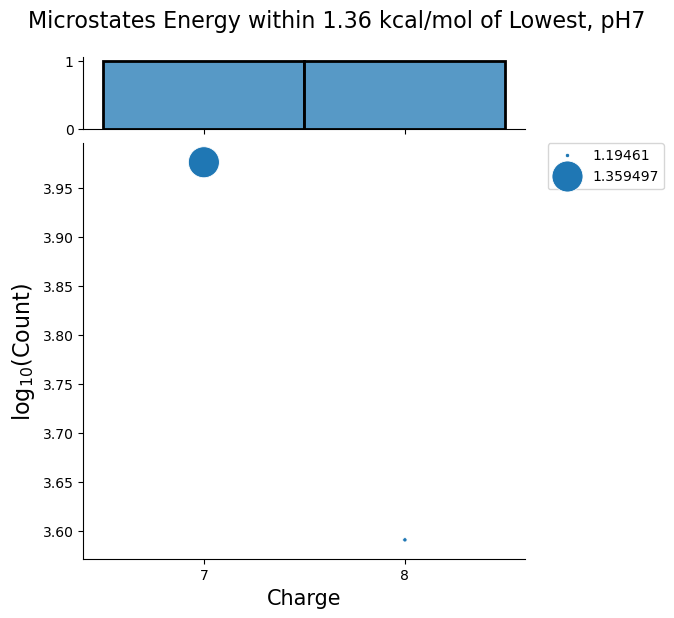

In [178]:
title = "Microstates Energy within 1.36 kcal/mol of Lowest, pH7" 
msa.jointplot(lowest_crgms_files,
              background_crg,
              title,
              out_dir=output_dir,
              save_name="crgms_logcount_vs_lowest_E.pdf",
              show=True)

#### This is to get the unique charge microstates within +/- 0.5 pH unit (+/- 0.68 kcal/mol) of average microstate energy

In [179]:
begin_mc_aver = mc.average_E - 0.68
end_mc_aver = mc.average_E + 0.68
print(f"Using the average microstate energy +/- 0.5 pH unit (+/- 0.68 kcal/mol): ({begin_mc_aver}, {end_mc_aver})")

average_crgms_files = msa.findUniqueCrgmsCountOrder(crg_orig_lst,
                                                    begin_energy = begin_mc_aver,
                                                    end_energy = end_mc_aver
                                                    )
av_crg_count_res = msa.ConcaCrgMsPandas(average_crgms_files[0],
                                        average_crgms_files[1],
                                        average_crgms_files[2], 
                                        free_residues_df,
                                        background_charge,
                                        res_of_interest
                                       )

[INFO]: find_uniq_crgms_count_order:
	Number of energy-filtered charge ms: 93,790


Using the average microstate energy +/- 0.5 pH unit (+/- 0.68 kcal/mol): (-180.07293514108827, -178.71293514108825)


[INFO]: find_uniq_crgms_count_order:
	Number of unique charge ms: 9


In [24]:
# Sample data (uncomment to display):

#av_crg_count_res.head(3) 

[INFO]: jointplot:
	Figure saved: crgms_wc/crgms_logcount_vs_aver_E.pdf
[INFO]: jointplot:
	Figure saved: crgms_wc/crgms_logcount_vs_aver_E.png


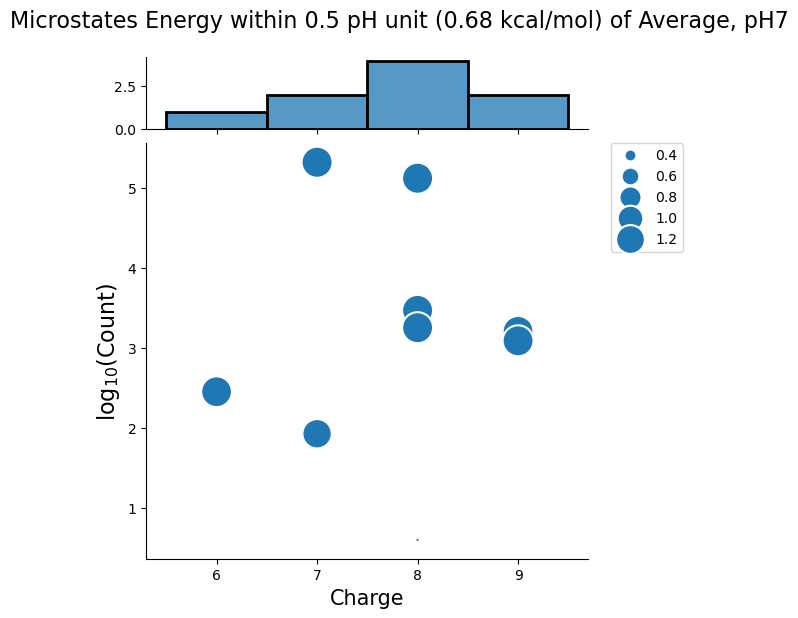

In [180]:
title = "Microstates Energy within 0.5 pH unit (0.68 kcal/mol) of Average, pH7" 
msa.jointplot(average_crgms_files,
              background_crg,
              title,
              out_dir=output_dir,
              save_name="crgms_logcount_vs_aver_E.pdf",
              show=True)

#### This is to get the unique charge microstates >= 1 KT unit (1.36 kcal/mol) of highest microstate energy

In [181]:
highest_crgms_files = msa.findUniqueCrgmsCountOrder(crg_orig_lst,
                                                    begin_energy = (mc.highest_E - 1.36),
                                                    end_energy = mc.highest_E
                                                    )
high_crg_count_res = msa.ConcaCrgMsPandas(highest_crgms_files[0],
                                          highest_crgms_files[1],
                                          highest_crgms_files[2], 
                                          free_residues_df,
                                          background_charge,
                                          res_of_interest)

[INFO]: find_uniq_crgms_count_order:
	Number of energy-filtered charge ms: 9
[INFO]: find_uniq_crgms_count_order:
	Number of unique charge ms: 3


In [28]:
# Sample data (uncomment to display):

#high_crg_count_res.head(3) 

[INFO]: jointplot:
	Figure saved: crgms_wc/crgms_logcount_vs_highest_E.pdf
[INFO]: jointplot:
	Figure saved: crgms_wc/crgms_logcount_vs_highest_E.png


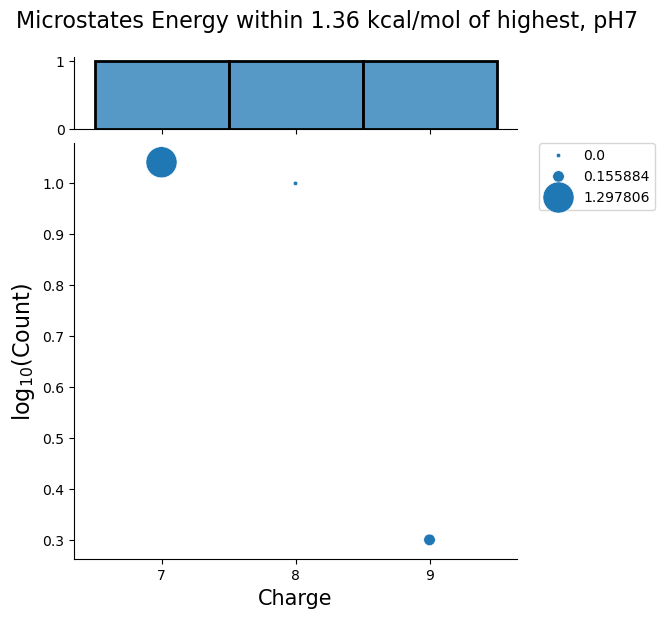

In [182]:
title = "Microstates Energy within 1.36 kcal/mol of highest, pH7"
msa.jointplot(highest_crgms_files,
              background_crg,
              title,
              out_dir=output_dir,
              save_name="crgms_logcount_vs_highest_E.pdf",
              show=True)

# TODO:
 * try these other plotting fns:
   - 'plot_hist_by_ms_energy'
   - 'plots_unique_crg_histogram'

## Save all these 3 DataFrames and non titrable residues charge information:
 * low_crg_count_res
 * av_crg_count_res
 * high_crg_count_res
 * fixed_resoi_crg_df

In [30]:
# Writing to Excel will fail if xlswriter is not installed:
# see https://anaconda.org/conda-forge/xlsxwriter
try:
    # this will be a user specified name:
    xl_filename = "charge_ms_dry2_semi_pH7.xlsx"
    outfile_xl = output_dir.joinpath(xl_filename)

    # Create an ExcelWriter object
    with pd.ExcelWriter(outfile_xl,
                        engine="xlsxwriter"
                       ) as writer:
        # Write your dataframes to different sheets
        low_crg_count_res.to_excel(writer, sheet_name='low_crg_count_res')
        av_crg_count_res.to_excel(writer, sheet_name='av_crg_count_res')
        high_crg_count_res.to_excel(writer, sheet_name='high_crg_count_res')
        fixed_resoi_crg_df.to_excel(writer, sheet_name='fixed_residues_crg')

        # Save the Excel file
        writer.save()
        print(f"Saved Excel file {outfile_xl!s}.")

except Exception as e:
    if type(e).__name__ == "ModuleNotFoundError":
        print("The excel writer engine must be installed;", e)
    else:
        print(f"Error occurred while saving Excel file: {str(e)}")

The excel writer engine must be installed; No module named 'xlsxwriter'


In [ ]:
if n_fixed_resoi:
    fixed_resoi_crg_df.head(3)

In [183]:
# Save all_crg_count_res DataFrame to a CSV file:
# Due to column size issue in excel for large sytem. We save all_crg_count_res in csv format.

crg_count_csv = output_dir.joinpath("all_crg_count_res.csv")

try:
    all_crg_count_res.to_csv(crg_count_csv, header=True)
    print(f"DataFrame all_crg_count_res saved to {crg_count_csv!s}.")

except Exception as e:
    print(f"Error occurred while saving all_crg_count_res to csv file: {str(e)}")

DataFrame all_crg_count_res saved to crgms_wc/all_crg_count_res.csv.


---
# Post-processing of already saved main crgms file to get the correlation matrix for residues. 

In [195]:
# This is for correlation.

all_crg_count_read = pd.read_csv(crg_count_csv, index_col=0)
all_crg_count_read 

,NTRA0001_,LYSA0001_,HISA0015_,TYRA0020_,TYRA0023_,GLUA0035_,ASPA0119_,Count,Occupancy,Sum_crg_protein
Order,,,,,,,,,,
1.0,0.0,1.0,0.0,0.0,0.0,-1.0,-1.0,902236.0,0.601,7.0
2.0,0.0,1.0,1.0,0.0,0.0,-1.0,-1.0,545491.0,0.364,8.0
3.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,18153.0,0.012,8.0
4.0,1.0,1.0,0.0,0.0,0.0,-1.0,-1.0,11926.0,0.008,8.0
5.0,0.0,1.0,1.0,0.0,0.0,0.0,-1.0,10356.0,0.007,9.0
6.0,1.0,1.0,1.0,0.0,0.0,-1.0,-1.0,7470.0,0.005,9.0
8.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,2214.0,0.001,6.0
7.0,0.0,0.0,1.0,0.0,0.0,-1.0,-1.0,1385.0,0.001,7.0
9.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,250.0,0.000,8.0


In [198]:
# drop if the protonation is not changing in free residues

all_crg_change_df = msa.changing_residues_df(all_crg_count_read)

[INFO]: changing_residues_df:
	Number of residues that change protonation state: 5


# TODO:
 * Output file ~ "crg_count_res_of_interest"
 * After heatmap: Add fixed res of interest in same file for saving
 * Sort matrix to prevent "scattered hot spots"

In [200]:
# this is for demo: choose your favorite resids:

df_choose_res_data = msa.choose_res_data(all_crg_change_df, choose_res)
df_choose_res_data["Occupancy"] = round(df_choose_res_data["Count"]/sum(df_choose_res_data["Count"]), 2)
df_choose_res_data

file_name = f"cluster{len(choose_res)}_crg_count_res.csv"
df_choose_res_data.to_csv(output_dir.joinpath(file_name), header=True)

,GLUA0035_,HISA0015_,ASPA0119_,Count,Occupancy
0,-1.0,0.0,-1.0,916422.0,0.61
1,-1.0,1.0,-1.0,554361.0,0.37
2,0.0,0.0,-1.0,18314.0,0.01
3,0.0,1.0,-1.0,10461.0,0.01
4,-1.0,0.0,0.0,280.0,0.00
5,-1.0,1.0,0.0,162.0,0.00


In [201]:
df_chosen_res_renamed = msa.renameOrderResidues(df_choose_res_data)
df_chosen_res_renamed

,AE35,AD119,AH15,Count
0,-1.0,-1.0,0.0,916422.0
1,-1.0,-1.0,1.0,554361.0
2,0.0,-1.0,0.0,18314.0
3,0.0,-1.0,1.0,10461.0
4,-1.0,0.0,0.0,280.0
5,-1.0,0.0,1.0,162.0


# TODO: Check size of df: if not > 1: no need for correlation processing

# Weighted correlation

In [202]:
if df_chosen_res_renamed.shape[0] > 1:
    df_correlation = msa.WeightedCorr(df=df_chosen_res_renamed, wcol="Count")(method="pearson")
    df_correlation
else:
    print("Too few rows for correlation.")

,AE35,AD119,AH15
AE35,1.000000,-0.002401,-0.003784
AD119,-0.002401,1.000000,-0.000359
AH15,-0.003784,-0.000359,1.000000


## FIX: Does not work.
#### what is the expected output?

## Create a heatmap to display the residue correlation:
 * Kept `correl_heatmap` in notebook for tweaking

 * Existing function: `msa.corr_heat_map`
 ```
    def corr_heat_map(df_corr: pd.DataFrame, out_dir: Path, save_name: str = "corr.pdf", show: bool = False):
 ```

[INFO]: corr_heat_map:
	Correlation heat map saved as crgms_wc/corr.pdf


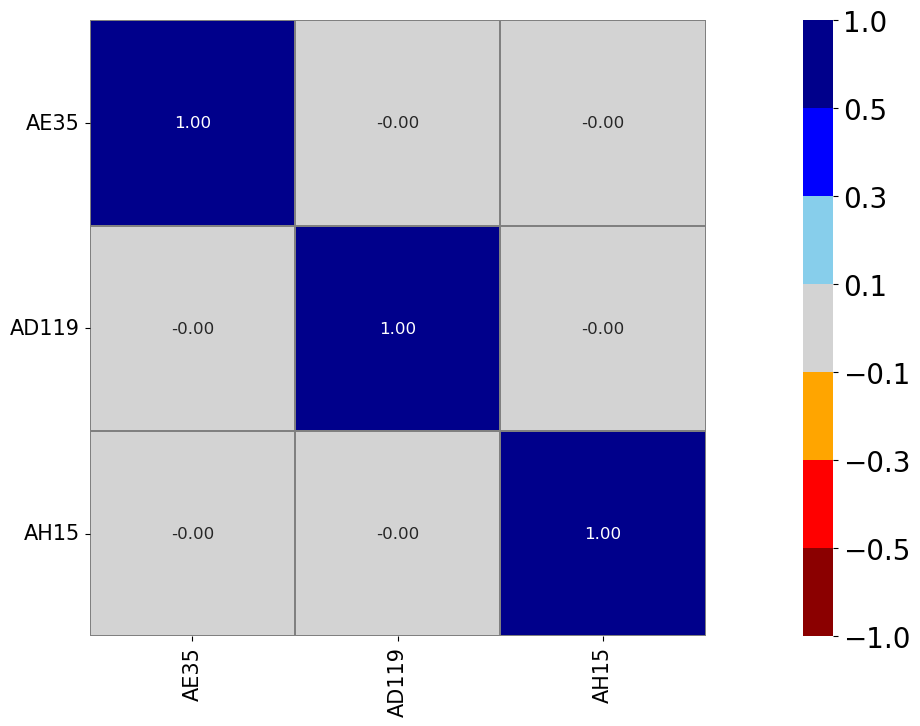

In [203]:
msa.corr_heat_map(df_correlation,
                  out_dir=output_dir,
                  save_name="corr.pdf",
                  show=True)

In [40]:
def correl_heatmap(correl_df: pd.DataFrame, out_dir: str, fig_name: str, show: bool = False):
    
    plt.figure(figsize=(25, 8))
    cmap = ListedColormap(["darkred", "red", "pink", "lightgray","skyblue", "blue", "darkblue"])
    bounds = [-1.0, -0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 1.0]
    norm = BoundaryNorm(bounds, cmap.N)
    heatmap = sns.heatmap(correl_df,
                          linecolor="gray",
                          cmap=cmap,
                          norm=norm,
                          square=True,
                          fmt=".2f",
                          linewidths=.01,
                          annot=True,
                          annot_kws={"fontsize":12}
                         )
    heatmap.set_title("Loaded", fontdict={"fontsize":18}, pad=16)
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)
    
    plt.ylabel(None)
    plt.xlabel(None)
    plt.yticks(fontsize = 15, rotation = 0)
    plt.xticks(fontsize = 15, rotation = 90)

    corr_pdf = Path(out_dir).joinpath(fig_name)
    plt.savefig(corr_pdf, dpi=600, bbox_inches="tight");
    print(f"Figure saved: {corr_pdf!s}")
    if show:
        plt.show()

    return

Using correl_heatmap:
Figure saved: crgms_wc/corr.pdf


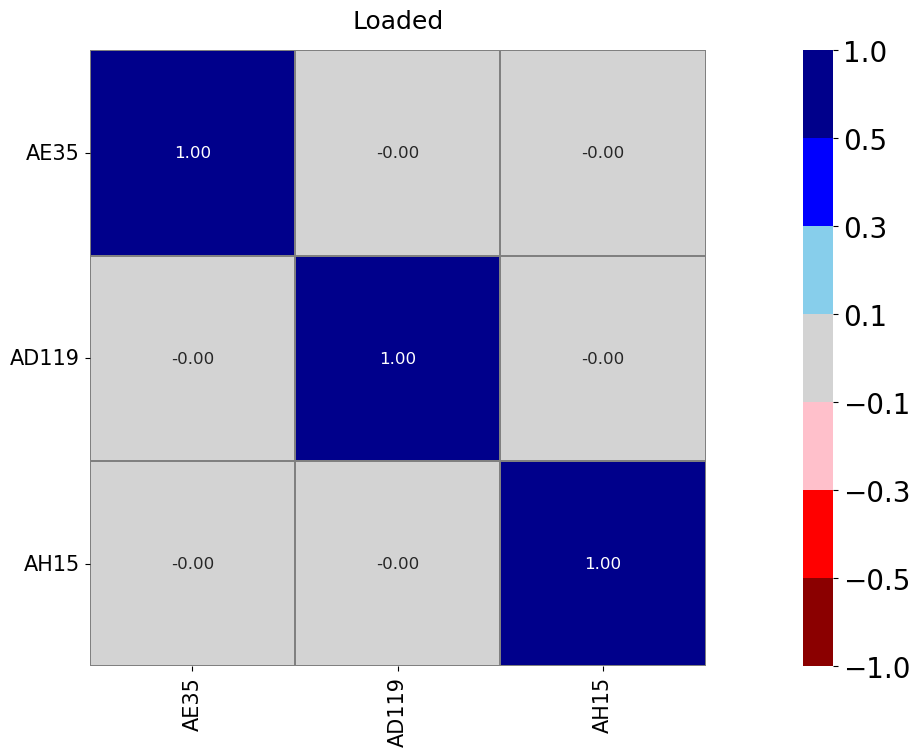

In [41]:
print("Using correl_heatmap:")

correl_heatmap(df_correlation, 
               out_dir=output_dir, fig_name="corr.pdf",
               show=True)

In [45]:
msa.plots_unique_crg_histogram?

Signature:
msa.plots_unique_crg_histogram(
    charge_ms_info: tuple,
    background_charge: float,
    out_dir: pathlib.Path,
    save_name: str,
    show: bool = False,
)
Docstring:
Visualize which tautomer charge state is most populated.
This includes the background charge.
File:      ~/projects/raihan/python/microstate_analysis_code/ms_analysis_wc.py
Type:      function

In [48]:
# Show in notebook:

msa.plot_hist_by_ms_energy?

Signature:
msa.plot_hist_by_ms_energy(
    ms_by_enrg: list,
    out_dir: pathlib.Path,
    save_name: str = 'enthalpy_dist.pdf',
    show: bool = False,
)
Docstring: <no docstring>
File:      ~/projects/raihan/python/microstate_analysis_code/ms_analysis_wc.py
Type:      function